# Assignment 4. Denoising Diffusion Probabilistic Models (DDPM)

The goal of this exercise is to get familiar with diffusion-based generative models using the DDPM model as an example. The model is proposed in [this paper](https://arxiv.org/pdf/2006.11239.pdf).

**This exercise requires a significant amount of computing power, we recommend you to use a GPU if you have access to one.**

In [35]:
import time
import matplotlib.pyplot as plt
import numpy as np
import random

import torch
import torchvision
import torchvision.utils as utils
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

import fd

In [36]:
skip_training = False  # Set this flag to True before validation and submission

In [37]:
# During evaluation, this cell sets skip_training to True
# skip_training = True

import tools, warnings
warnings.showwarning = tools.customwarn

In [38]:
# When running on your own computer, you can specify the data directory by:
# data_dir = tools.select_data_dir('/your/local/data/directory')
data_dir = tools.select_data_dir()

The data directory is /coursedata


In [39]:
# Select the device for training (use GPU if you have one)
device = torch.device('cpu')
#device = torch.device('cuda:0')

In [40]:
if skip_training:
    # The models are always evaluated on CPU
    device = torch.device('cpu')

## Data

In this exercise, we use standard MNIST data. To simplify the construction of the denoising model (U-net), we upscale the images to $32\times 32$ resolution.

In [41]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Transform to tensor
    transforms.Resize((32, 32)),
    transforms.Normalize((0.5,), (0.5,))  # Scale images to [-1, 1]
])

trainset = torchvision.datasets.MNIST(root=data_dir, train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

In [42]:
def show_images(images, ncol=12, figsize=(8,8), **kwargs):
    fig, ax = plt.subplots(figsize=figsize)
    ax.axis('off')
    out = rearrange(images, '(b1 b2) c h w -> c (b1 h) (b2 w)', b2=ncol).cpu()
    if out.shape[0] == 1:
        ax.matshow(out[0], **kwargs)
    else:
        ax.imshow(out.permute((1, 2, 0)), **kwargs)
    display.display(fig)
    plt.close(fig)

torch.Size([128, 1, 32, 32])


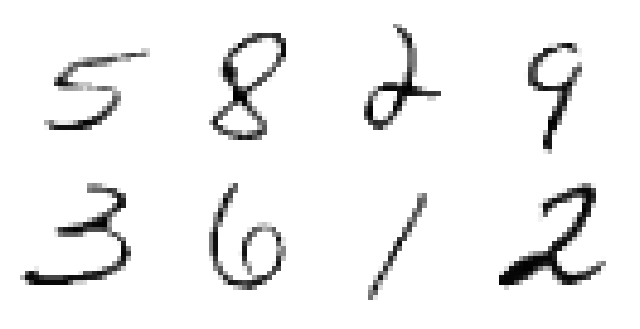

In [43]:
images, labels = next(iter(trainloader))
print(images.shape)
tools.show_images(images[:8], ncol=4, cmap='binary', clim=[0,1])

## Diffusion model (2 points)

In DDPM, the forward process (or diffusion process) is a Markov chain that gradually adds Gaussian noise to the data according to a variance schedule $\beta_1, ..., \beta_T$:
$$
q(x_{1:T} | x_0) = \prod^T_{t=1} q(x_t|x_{t−1}), \quad q(x_t|x_{t−1}) = N (x_t; \sqrt{1 − \beta_t} x_{t−1}, \beta_t I)
$$

* In our implementation of DDPM, we use a linear schedule for $\beta_t$ that grows linearly from 0.0001 to 0.02 with T=1000 time steps in total. Please store the values of $\beta_t$ in attribute `self.betas`.

* We implement the forward diffusion process in function `forward()`. This function receives a clearn sample $x_0$ and a noise instance $\epsilon_t$ and returns
$$
x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon_t
$$
which is a sample from the following distribution:
$$
q(x_t|x_0) = N(x_t; \sqrt{\bar{\alpha}_t} x_{0}, (1 - \bar{\alpha}_t) I)
$$
where
$$
\bar{\alpha}_t = \prod^t_{s=1} \alpha_s
\qquad
\alpha_t = 1 − \beta_t.
$$
Note that the denoising model is trained to predict the noise instance $\epsilon_t$ which is why we create it outside of the function.

* Samples are generated with an inverse diffusion process which we implement in function `sample()`. The sampling process is described in Algorithm 2 of the paper:
<img src="alg_sampling.png" width=350>
where $\sigma_t = \sqrt{\beta_t}$.


In [44]:
class Diffusion(nn.Module):
    """Diffusion model with a linear schedule of the temperatures.
    """
    def __init__(self, num_timesteps=1000):
        super().__init__()

        self.num_timesteps = num_timesteps
        self.inference_steps = torch.arange(self.num_timesteps-1, -1, -1)

        # YOUR CODE HERE
        self.register_buffer('betas', torch.linspace(0.0001, 0.02, self.num_timesteps))
        self.register_buffer('alphas', 1 - self.betas)
        self.register_buffer('alphas_cumprod', torch.cumprod(self.alphas, dim = 0))
        #raise NotImplementedError()

    def forward(self, x, t, noise=None):
        """
        Args:
          x of shape (batch_size, ...): Input samples.
          t of shape (batch_size,): Corruption temperatures.
          noise of shape (batch_size, ...): Noise instanses used for corruption.
          
        Returns:
          noisy sample of the same shape
        """
        # YOUR CODE HERE
        if noise is None:
            noise = torch.randn_like(x)
        
        alpha_t_cum = self.alphas_cumprod[t].reshape(-1,1,1,1)
        x_t = torch.sqrt(alpha_t_cum)*x + torch.sqrt(1-alpha_t_cum)*noise
        return x_t
        #raise NotImplementedError()

    @torch.no_grad()
    def reverse_step(self, x, t, noise_pred):
        """
        Args:
          x of shape (batch_size, ...): Noisy samples at current corruption level: x_t.
          t (int): Corruption timestep.
          noise_pred of shape (batch_size, ...): Noise predicted by a denoising model.
        
        Returns:
          prediction of x_{t - 1} of shape (batch_size, ...)
        """

        # YOUR CODE HERE
        beta_t = self.betas[t]
        sigma_t = torch.sqrt(beta_t)
        z = torch.randn_like(x) if t>0 else 0
        alpha_t_cum = self.alphas_cumprod[t].reshape(-1,1,1,1)
        alpha_t = self.alphas[t]
        x_prev = (x - ((1-alpha_t)/torch.sqrt(1-alpha_t_cum))*noise_pred)/torch.sqrt(alpha_t) + sigma_t*z
        return x_prev
        #raise NotImplementedError()


    @torch.no_grad()
    def sample(self, model, x_shape, labels, init_x=None, return_sequence=False):
        """
        Args:
          model: A denoising model. model(x, t, labels) takes as inputs:
                   x of shape (batch_size, n_channels, H, W): corrupted examples.
                   t of shape (batch_size,): LongTensor of time steps.
                   labels of shape (batch_size,): LongTensor of the classes of the examples in x.
                 and outputs a denoised version of input x.
          x_shape: The shape of the generated data. For example, to generate batch_size images of shape (1, H, W),
                   x_shape should be (batch_size, 1, H, W).
          labels of shape (batch_size,): LongTensor of the classes of generated samples.
          init_x: Optional tensor of shape `x_shape`, providing the initial noisy input (x_T).
                  If None, x_T is sampled from the gaussian prior.

          return_sequence: If True, returns the entire denoising trajectory [x_T, ..., x_0].
                           If False, only the final sample x_0 is returned.

        Returns:
            If return_sequence is False:
                - A tensor of shape (batch_size, n_channels, H, W) containing the final samples.
            If return_sequence is True:
                - A tuple (x_0, trajectory), where trajectory is a list of tensors representing
                  the intermediate states [x_T, ..., x_0].
              
        Note: Create new tensors on the same device where the model is.
        """
        batch_size = x_shape[0]
        assert labels is None or batch_size == len(labels), "Sample batch size different from length of given labels"

        if init_x is None:
            # YOUR CODE HERE
            x = torch.randn(x_shape)
            #raise NotImplementedError()
        else:
            assert x_shape == init_x.shape, f"Expected shape {x_shape}, but got {init_x.shape}"
            x = init_x

        if return_sequence:
            x_sequence = [x]

        for t in self.inference_steps:
            # compute noise prediction below
            # YOUR CODE HERE
            noise_pred = model(x, t, labels)
            #raise NotImplementedError()
            
            x = self.reverse_step(x, t, noise_pred)
            
            if return_sequence:
                x_sequence.append(x)

        if not return_sequence:
            return x
        else:
            return x, x_sequence


def extract(a, t_batch, ndim):
    """
    Args:
      a: tensor of shape [T]
      t_batch: tensor of shape [batch_size]
      ndim (int)

    Returns:
      out of shape [batch_size, 1, ..., 1] where the number of 1s is equal to ndim-1.
    """
    dims = (1,) * (ndim-1)
    out = a[t_batch].view(-1, *dims)  # (batch_size, 1, 1, 1) to allow multiplication by x
    return out

In [45]:
diffusion = Diffusion(1000)
assert diffusion.betas[0] == 1e-4, "The lowest temperature should be 1e-4"
assert diffusion.betas[-1] == 0.02, "The highest temperature should be 0.02"
assert len(diffusion.betas) == 1000, "The number of steps should be 1000"

def test_diffusion_forward_shapes():
    diffusion = Diffusion(1000)
    batch_size = 2
    x = torch.randn(batch_size, 1, 32, 32)
    t = torch.LongTensor([500, 900])

    out = diffusion.forward(x, t)
    assert out.shape == x.shape, f"Bad out.shape: {out.shape}"

    noise = torch.randn_like(x)
    out = diffusion.forward(x, t, noise)
    assert out.shape == x.shape, f"Bad out.shape: {out.shape}"
    print('Success')

test_diffusion_forward_shapes()

Success


In [46]:
def test_diffusion_forward():
    diffusion = Diffusion(1000)
    batch_size = 2
    x = 2 * torch.ones(batch_size, 1, 32, 32)
    t = torch.LongTensor([500, 900])
    noise = torch.ones_like(x)
    out = diffusion.forward(x, t, noise)
    expected = torch.empty_like(x)
    expected[0].fill_(1.51815533)
    expected[1].fill_(1.03274309)

    print('out:\n', out)
    print('expected correct:\n', expected)
    assert torch.allclose(expected, out), "out does not match the expected value."
    print('Success')

out = test_diffusion_forward()

out:
 tensor([[[[1.5182, 1.5182, 1.5182,  ..., 1.5182, 1.5182, 1.5182],
          [1.5182, 1.5182, 1.5182,  ..., 1.5182, 1.5182, 1.5182],
          [1.5182, 1.5182, 1.5182,  ..., 1.5182, 1.5182, 1.5182],
          ...,
          [1.5182, 1.5182, 1.5182,  ..., 1.5182, 1.5182, 1.5182],
          [1.5182, 1.5182, 1.5182,  ..., 1.5182, 1.5182, 1.5182],
          [1.5182, 1.5182, 1.5182,  ..., 1.5182, 1.5182, 1.5182]]],


        [[[1.0327, 1.0327, 1.0327,  ..., 1.0327, 1.0327, 1.0327],
          [1.0327, 1.0327, 1.0327,  ..., 1.0327, 1.0327, 1.0327],
          [1.0327, 1.0327, 1.0327,  ..., 1.0327, 1.0327, 1.0327],
          ...,
          [1.0327, 1.0327, 1.0327,  ..., 1.0327, 1.0327, 1.0327],
          [1.0327, 1.0327, 1.0327,  ..., 1.0327, 1.0327, 1.0327],
          [1.0327, 1.0327, 1.0327,  ..., 1.0327, 1.0327, 1.0327]]]])
expected correct:
 tensor([[[[1.5182, 1.5182, 1.5182,  ..., 1.5182, 1.5182, 1.5182],
          [1.5182, 1.5182, 1.5182,  ..., 1.5182, 1.5182, 1.5182],
          [1.5

In [47]:
class DummyModel(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, t, labels=None):
        return x

def test_diffusion_sample_shapes():
    diffusion = Diffusion(1000).to(device)
    batch_size = 2
    x_shape = (batch_size, 1, 32, 32)
    model = DummyModel()

    
    out = diffusion.sample(model, x_shape, labels=None)
    assert out.shape == x_shape, f"Bad out.shape: {out.shape}"
    print('Success')

test_diffusion_sample_shapes()

Success


In [48]:
import unittest.mock

def my_randn_like(x):
    return torch.ones_like(x)

def my_randn(*args, **kwargs):
    return torch.ones(*args, **kwargs)

def my_normal(mean, std, **kwargs):
    return mean + std * torch.ones_like(std)

@unittest.mock.patch('torch.randn_like', my_randn_like)
@unittest.mock.patch('torch.randn', my_randn)
@unittest.mock.patch('torch.normal', my_normal)
def test_diffusion_sample():
    diffusion = Diffusion(10)
    model = DummyModel()
    batch_size = 2
    x_shape = (batch_size, 1, 32, 32)

    out = diffusion.sample(model, x_shape, labels=None)
    expected = torch.empty(x_shape).fill_(1.3058254)
    print('out:\n', out)
    print('expected correct:\n', expected)
    assert torch.allclose(expected, out), "out does not match the expected value."
    print('Success')

test_diffusion_sample()

out:
 tensor([[[[1.3058, 1.3058, 1.3058,  ..., 1.3058, 1.3058, 1.3058],
          [1.3058, 1.3058, 1.3058,  ..., 1.3058, 1.3058, 1.3058],
          [1.3058, 1.3058, 1.3058,  ..., 1.3058, 1.3058, 1.3058],
          ...,
          [1.3058, 1.3058, 1.3058,  ..., 1.3058, 1.3058, 1.3058],
          [1.3058, 1.3058, 1.3058,  ..., 1.3058, 1.3058, 1.3058],
          [1.3058, 1.3058, 1.3058,  ..., 1.3058, 1.3058, 1.3058]]],


        [[[1.3058, 1.3058, 1.3058,  ..., 1.3058, 1.3058, 1.3058],
          [1.3058, 1.3058, 1.3058,  ..., 1.3058, 1.3058, 1.3058],
          [1.3058, 1.3058, 1.3058,  ..., 1.3058, 1.3058, 1.3058],
          ...,
          [1.3058, 1.3058, 1.3058,  ..., 1.3058, 1.3058, 1.3058],
          [1.3058, 1.3058, 1.3058,  ..., 1.3058, 1.3058, 1.3058],
          [1.3058, 1.3058, 1.3058,  ..., 1.3058, 1.3058, 1.3058]]]])
expected correct:
 tensor([[[[1.3058, 1.3058, 1.3058,  ..., 1.3058, 1.3058, 1.3058],
          [1.3058, 1.3058, 1.3058,  ..., 1.3058, 1.3058, 1.3058],
          [1.3

We can visualize the forward process in the cell below. Note that since `Diffusion.forward()` samples independent noise instances for different time steps $t$, the illustration below does **not** correspond to steps of the same diffusion process.

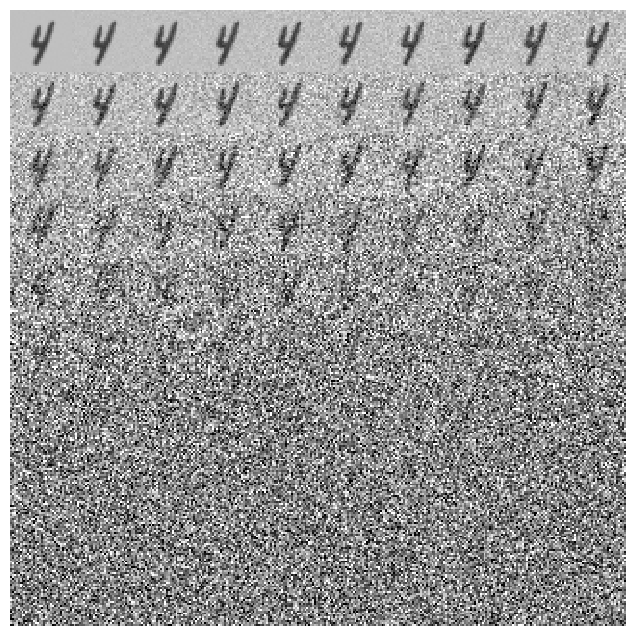

In [49]:
diffusion = Diffusion(1000)
t = torch.arange(0, diffusion.num_timesteps, 10)
x, _ = random.choice(trainset)
x = x[None, ...].tile(len(t), 1, 1, 1)  # (t_steps, c, h, w)

x_perturbed = diffusion.forward(x, t)
tools.show_images(x_perturbed, ncol=10, cmap='binary', clim=[-2, 2])

## Construct the denoising model (1 point)

A denoising model is the model that predicts the noise instance $\epsilon$
$$
  \epsilon = f(\tilde{x}, t, y)
$$
that was used to generate the corrupted sample $\tilde{x}$ with the corruption level defined by time step $t$. For denoising conditioned on label $y$, the model additionally accepts the label information $y$.

The output $\epsilon$ of the model should have the same dimensionality as the input $\tilde{x}$. The architecture that is very commonly used for $f$ is a U-net.

The U-Net architecture is fixed, with all layers pre-defined in the `__init__()` method. Your task is to implement the forward pass.

**Notes:** 

* The model uses blocks `ResidualBlock`, `Downsample` and `PositionalEmbedding` defined in `blocks.py`.
* To enable conditioning on time step $t$, we encode the time step using an MLP.
  
* The encoder is a sequence of the following blocks:
  * A convolutional layer with 3x3 kernel, `base_channels` output channels, which keeps the resolution of the input.
  * `ResidualBlock` with `base_channels` output channels.
  * `Downsample` layer which preserves the number of channels.
  * `ResidualBlock` with `2*base_channels` output channels.
  * `Downsample` layer which preserves the number of channels.
  * `ResidualBlock` with `2*base_channels` output channels.
  * `Downsample` layer which preserves the number of channels.
  * `ResidualBlock` with `2*base_channels` output channels.

* The encoder is followed by a bottleneck layer which is
  * `ResidualBlock` with `2*base_channels` output channels.
  
* The decoder is a sequence of the following blocks:
  * `ResidualBlock` with `2*base_channels` output channels.
  * `ResidualBlock` with `2*base_channels` output channels.
  * `Upsample` layer which preserves the number of channels.

  * `ResidualBlock` with `2*base_channels` output channels.
  * `ResidualBlock` with `2*base_channels` output channels.
  * `Upsample` layer which preserves the number of channels.

  * `ResidualBlock` with `2*base_channels` output channels.
  * `ResidualBlock` with `base_channels` output channels.
  * `Upsample` layer which preserves the number of channels.

  * `ResidualBlock` with `base_channels` output channels.
  * `ResidualBlock` with `base_channels` output channels.
  * A convolutional layer with 3x3 kernel, `img_channels` output channels, which keeps the resolution of the input.
  

* Each residual block receives the time-step embedding produced by the MLP defined above and the label of a sample as extra inputs.
  
* The inputs of the decoder residual blocks are concatenations of two signals: the output of the previous decoder layer and the skip signal produced by the corresponding layer of the encoder.

* There are 8 skip signals in totals: they are the outputs of the first convolutional layer and the encoder blocks of type `ResidualBlock` and `Downsample`.

* `Upsample` layers of the decoder do not receive skip signals.

In [50]:
from blocks import ResidualBlock, Downsample, Upsample, PositionalEmbedding


class UNet(nn.Module):
    """The denoising model.

    Args:
      img_channels (int): Number of image channels.
      base_channels (int): Number of base channels.
      time_emb_dim (int or None): The size of the embedding vector produced by the MLP which embeds the time input.
      num_classes (int or None): Number of classes.
    """

    def __init__(self, img_channels, base_channels, time_emb_dim=None, num_classes=None):
        super().__init__()

        self.num_classes = num_classes
        self.time_mlp = nn.Sequential(
            PositionalEmbedding(base_channels),
            nn.Linear(base_channels, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim),
        ) if time_emb_dim is not None else None


        # Encoder
        self.init_conv = nn.Conv2d(img_channels, base_channels, 3, padding=1)

        self.enc11 = ResidualBlock(base_channels, base_channels, time_emb_dim, num_classes)
        self.down1 = Downsample(base_channels)
        self.enc21 = ResidualBlock(base_channels, 2*base_channels, time_emb_dim, num_classes)
        self.down2 = Downsample(2*base_channels)
        self.enc31 = ResidualBlock(2*base_channels, 2*base_channels, time_emb_dim, num_classes)
        self.down3 = Downsample(2*base_channels)
        self.enc41 = ResidualBlock(2*base_channels, 2*base_channels, time_emb_dim, num_classes)

        self.encoder_layers = [
            self.enc11, self.down1,
            self.enc21, self.down2,
            self.enc31, self.down3,
            self.enc41,
        ]

        self.mid1 = ResidualBlock(2*base_channels, 2*base_channels, time_emb_dim, num_classes)
        
        # Decoder
        self.dec11 = ResidualBlock(2*base_channels*2, 2*base_channels, time_emb_dim, num_classes)
        self.dec13 = ResidualBlock(2*base_channels*2, 2*base_channels, time_emb_dim, num_classes)
        self.up1 = Upsample(2*base_channels)

        self.dec21 = ResidualBlock(2*base_channels*2, 2*base_channels, time_emb_dim, num_classes)
        self.dec23 = ResidualBlock(2*base_channels*2, 2*base_channels, time_emb_dim, num_classes)
        self.up2 = Upsample(2*base_channels)

        self.dec31 = ResidualBlock(2*base_channels*2, 2*base_channels, time_emb_dim, num_classes)
        self.dec33 = ResidualBlock(2*base_channels + base_channels, base_channels, time_emb_dim, num_classes)
        self.up3 = Upsample(base_channels)

        self.dec41 = ResidualBlock(base_channels*2, base_channels, time_emb_dim, num_classes)
        self.dec43 = ResidualBlock(base_channels*2, base_channels, time_emb_dim, num_classes)

        self.decoder_layers = [
            self.dec11, self.dec13, self.up1,
            self.dec21, self.dec23, self.up2,
            self.dec31, self.dec33, self.up3,
            self.dec41, self.dec43,
        ]

        self.out_conv = nn.Conv2d(base_channels, img_channels, 3, padding=1)

    def forward(self, x, time=None, labels=None):
        """Estimate noise instances used to produced corrupted examples `x` with the corruption level determined
        by `time`. `labels` contains the class information of the examples in `x`.

        Args:
          x of shape (batch_size, n_channels, H, W): Corrupted examples.
          time of shape (batch_size,): LongTensor of time steps which determine the corruption level for
                                       the examples in x.
          labels of shape (batch_size,): LongTensor of the classes of the examples in x.

        Returns:
          out of shape (batch_size, n_channels, H, W)
        """
        # YOUR CODE HERE
        time_emb = self.time_mlp(time)
        xs = []
        x = self.init_conv(x)
        xs.append(x)
        count = 0
        for enc in self.encoder_layers:
            if count%2 == 0:
                x = enc(x, time_emb, labels)
            else:
                x = enc(x)
            
            xs.append(x)
                
            count += 1
                      
        x = self.mid1(x, time_emb, labels)
        count = 1
        for dec in self.decoder_layers:
            
            if count%3 == 0:
                x = dec(x)
                
            else:
                xenc = xs.pop()
                
                x_ = torch.cat([x, xenc], dim = 1)
                x = dec(x_, time_emb, labels)
            count += 1
            
        x = F.relu(x)
        x = self.out_conv(x)
                
        return x
        
        #raise NotImplementedError()

In [51]:
def test_Unet_forward():
    torch.manual_seed(0)
    torch.cuda.manual_seed(0)
    unet = UNet(
        img_channels=1,
        base_channels=128,
        time_emb_dim=32,
        num_classes=11,
    )
    unet.eval()
    
    batch_size = 2
    x = torch.ones(batch_size, 1, 32, 32)
    t = torch.LongTensor([900, 900])
    labels = torch.LongTensor([0, 1])
    out = unet(x, t, labels)
    correct_out = torch.load('test_unet_output.pth', map_location=lambda storage, loc: storage)
    
    assert out.shape == x.shape, f"Bad out.shape: {out.shape}"
    assert torch.allclose(out, correct_out), "out does not match the expected value."
    print('Success')
    

test_Unet_forward()

Success


## Train the model (3 points)

Implement the training loop in the cell below.

The training procedure consists of the following steps for each mini-batch:
* Sample uniformly time steps from 0 to `Diffusion.num_timesteps-1` for each training example.
* Compute corrupted samples with `Diffusion.forward`.
* Estimate the noise used to generate the corrupted samples with the U-net model.
* The loss is the MSE loss between the estimated noise and the ground-truth noise.

The implementation should follow Algorithm 1 of the paper:
<img src="alg_training.png" width=350>

**The recommended hyperparameters:**
* Adam optimizer with learning rate 0.001
* Number of epochs: 15. On a CPU, each epoch takes approximately 10 minutes. Training for 5 epochs is typically sufficient to pass the tests.

**Conditional + Unconditional training:**
- You will train the model to handle both conditional and unconditional generation:
- The dataset includes $10$ digit classes, so we set ```num_classes = 11``` by adding one dummy class for unconditional training.
- During training, randomly replace 10% of the class labels with the dummy label. This allows the model to learn unconditional noise prediction.

**Hints:**
- The loss at convergence should reach 0.017 after about 11 epochs. We check that the loss is below 0.02 in the grading tests.
- You can track the training progress by plotting 120 generated samples and computing the FD score using the code below
```python
fdscore = fd.FDScore.pretrained(imsize=32)
fdscore.to(device)
...
with torch.no_grad():
    model.eval()
    x_shape = (120, 1, 32, 32)
    labels = torch.cat([torch.arange(10) for _ in range(12)], dim=0).to(device)
    samples = diffusion.sample(model, x_shape, labels)
    score = fdscore.calculate(samples)

    samples = ((samples + 1) / 2).clip(0, 1)
    tools.show_images(samples, cmap='binary', ncol=10)

    print(f'FD score: {score:.5f}')
```
- The FD score for a conditional model should be below 0.6 at convergence. We check that it is below 1 in the grading tests.
- **Do not forget to set the model into the training mode by `net.train()` before training.**
- The generated samples are expected to look similar to this:
<img src="diffusion_samples.png" width=400>

In [52]:
# Create a model
diffusion = Diffusion(1000)
model = UNet(
    img_channels=1,
    base_channels=32,
    time_emb_dim=32,
    num_classes=10 + 1,
)
diffusion.to(device);
model.to(device);

In [ ]:
if not skip_training:
    # YOUR CODE HERE
    epochs = 15
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
    criterion = nn.MSELoss()
    
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}:")
        epoch_loss = 0
        for images, labels in trainloader:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            t = torch.randint(0, diffusion.num_timesteps, (images.size(0),), device = device)
            noise = torch.randn_like(images).to(device)
            images_cor = diffusion.forward(images, t, noise)
            
            mask = torch.rand(labels.shape, device = device) < 0.9
            labels_to_use = torch.where(mask, labels,torch.full_like(labels, 10)) 
            noise_pred = model(images_cor, t, labels)
            loss = criterion(noise, noise_pred)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()
            
        print(f"Training loss: {epoch_loss/len(trainloader)}")
                
                
                
                
        fdscore = fd.FDScore.pretrained(imsize=32)
        fdscore.to(device)
        with torch.no_grad():
            model.eval()
            x_shape = (120, 1, 32, 32).to(device)
            labels = torch.cat([torch.arange(10) for _ in range(12)], dim=0).to(device)
            samples = diffusion.sample(model, x_shape, labels)
            score = fdscore.calculate(samples)
        
            samples = ((samples + 1) / 2).clip(0, 1)
            tools.show_images(samples, cmap='binary', ncol=10)
        
            print(f'FD score: {score:.5f}')
            
    #raise NotImplementedError()

Epoch 1:


In [ ]:
# Save the model to disk (the pth-files will be submitted automatically together with your notebook)
# Set confirm=False if you do not want to be asked for confirmation before saving.
if not skip_training:
    tools.save_model(diffusion, '1_diffusion.pth', confirm=True)
    tools.save_model(model, '1_unet.pth', confirm=True)

In [ ]:
if skip_training:
    diffusion = Diffusion(1000)
    model = UNet(
        img_channels=1,
        base_channels=32,
        time_emb_dim=32,
        num_classes=10 + 1,
    )

    tools.load_model(diffusion, '1_diffusion.pth', device)
    tools.load_model(model, '1_unet.pth', device)

### Generate samples

In [ ]:
model.eval();

In [ ]:
# Save generated samples (the pth-files will be submitted automatically together with your notebook)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
    
if not skip_training:
    with torch.no_grad():
        x_shape = (120, 1, 32, 32)
        init_x = torch.randn(*x_shape, device=device)
        labels = torch.cat([torch.arange(10) for _ in range(12)], dim=0).to(device)
        
        samples = diffusion.sample(model, x_shape, labels, init_x=init_x)
        torch.save(samples, '1_samples.pth')
else:
    samples = torch.load('1_samples.pth', map_location=lambda storage, loc: storage)


In [ ]:
fdscore = fd.FDScore.pretrained(imsize=32)
fdscore.to(device)
score = fdscore.calculate(samples)
print('FD score:', score)
assert score < 1, 'The FD score should be below 1'
print('Success')

In [ ]:
samples01 = ((samples + 1) / 2).clip(0, 1)
tools.show_images(samples01, cmap='binary', ncol=10)

In [ ]:
# This cell tests the training loss of the trained denoising model

## Classifier free guidance (1 point)

In this exercise, your objective is to **improve sample quality** by implementing **classifier-free guidance**. This method was introduced in [this paper](https://arxiv.org/abs/2207.12598).

#### Core Idea

Consider a conditional diffusion model that estimates $p(x \mid c)$, where $x$ is a sample (an image) and $c$ is a condition (a label).

Using Bayes' theorem, we can express the *implicit classifier* $p(c \mid x)$ as:

$$
\log p(c \mid x) = \log p(x \mid c) + \log p(c) - \log p(x).
$$

Note that  $p(x)$ is the unconditional model, which we approximate as $p(x \mid c = \emptyset)$. This insight allows us to guide the sampling process without needing an external classifier.

#### Guidance Formula

To apply this idea during sampling, we adjust the score as in classifier guidance:

$$
\nabla_x \left[\log p(x \mid c) + \omega \log p(c \mid x)\right]
$$

Substituting the expression for $\log p(c \mid x)$, we get:

$$\nabla_x[\log p(x | c) + \omega \log p(c | x)] = \nabla_x[\log p(x | c) + \omega (\log p(x| c) + \log p(c) - \log p(x))] = \nabla_x[\log p(x | c) (1 + \omega) - \omega \log p(x)].$$


Here, $\omega$ is a **guidance scale** that controls how strongly the conditioning influences the generation. Larger values of $\omega$ typically produce more faithful but potentially less diverse samples.

#### Reparametrization

In the denoising process, instead of directly modeling probabilities, we predict the noise $\epsilon_\theta$. Applying classifier-free guidance leads to the adjusted noise prediction:

$$
\tilde{\epsilon}_\theta(x | c) = (1 + \omega) \, \epsilon_\theta(x| c) - \omega \, \epsilon_\theta(x)
$$

- $ \epsilon_\theta(x| c) $: noise predicted *with* the condition.
- $ \epsilon_\theta(x) $: noise predicted *without* the condition.

In [ ]:
def sample_with_guidance(diffusion, model, x_shape, labels, init_x=None, return_sequence=False, guidance_scale=2.):
    """
    Args:
      diffusion: A diffusion model.
      model: A denoising model.
      x_shape: The shape of the generated data.
      labels of shape (batch_size,): LongTensor of the classes of generated samples.
      init_x: Optional tensor of shape `x_shape`, providing the initial noisy input (x_T).
              If None, x_T is sampled from the gaussian prior.

      return_sequence: If True, returns the entire denoising trajectory [x_T, ..., x_0].
                       If False, only the final sample x_0 is returned.
      guidance_scale: Parameter omega in the classifier-free guidance formula.

    Returns:
        If return_sequence is False:
            - A tensor of shape (batch_size, n_channels, H, W) containing the final samples.
        If return_sequence is True:
            - A tuple (x_0, trajectory), where trajectory is a list of tensors representing
              the intermediate states [x_T, ..., x_0].
    """
    with torch.no_grad():
        batch_size = x_shape[0]
        assert labels is None or batch_size == len(labels), "Sample batch size different from length of given labels"

        if init_x is None:
            # YOUR CODE HERE
            raise NotImplementedError()
        else:
            assert x_shape == init_x.shape, f"Expected shape {x_shape}, but got {init_x.shape}"
            x = init_x

        if return_sequence:
            x_sequence = [x]

        for t in diffusion.inference_steps:
            # compute noise prediction below
            # YOUR CODE HERE
            raise NotImplementedError()
            
            x = diffusion.reverse_step(x, t, noise_pred)

            if return_sequence:
                x_sequence.append(x)

        if not return_sequence:
            return x
        else:
            return x, x_sequence

In [ ]:
# Save generated samples (the pth-files will be submitted automatically together with your notebook)
torch.manual_seed(0)
torch.cuda.manual_seed(0)


if not skip_training:
    with torch.no_grad():
        x_shape = (120, 1, 32, 32)
        init_x = torch.randn(*x_shape, device=device)
        labels = torch.cat([torch.arange(10) for _ in range(12)], dim=0).to(device)
        
        samples = sample_with_guidance(diffusion, model, x_shape, labels=labels, init_x=init_x, guidance_scale=1.)
        torch.save(samples, '2_samples.pth')
else:
    samples = torch.load('2_samples.pth', map_location=lambda storage, loc: storage)


In [ ]:
fdscore = fd.FDScore.pretrained(imsize=32)
fdscore.to(device)
score = fdscore.calculate(samples)

baseline_samples = torch.load('1_samples.pth', map_location=lambda storage, loc: storage)
fd_score_baseline = fdscore.calculate(baseline_samples)

print('FD score:', score)
assert score < max(0.5, fd_score_baseline), 'The FD score should be below 0.5 or lower than the baseline'
print('Success')

In [ ]:
samples01 = ((samples + 1) / 2).clip(0, 1)
tools.show_images(samples01, cmap='binary', ncol=10)

## Accelerated sampling (3 points)

Diffusion models are highly effective at generating high-quality images. However, they tend to be significantly slower during inference than other generative models, primarily due to their sequential sampling process, which requires many iterative steps.

In this exercise, you will explore a technique that greatly accelerates inference without sacrificing sample quality. You will also gain the ability to perform deterministic sampling, which can be especially useful in applications where reproducibility or fine control is important.

Let us review the theoretical foundation behind this method.
### Denoising diffusion implicit model

Denoising diffusion implicit model was introduced in [this paper](). It proposes to use a non-Markovian inference distribution that induces the same marginals as DDPM. In particular, let the inference process be factorized as
$$
q_{\sigma, \tau}(x_{1:T} | x_0) = q_{\sigma, \tau}(x_{\tau_S} | x_0) \prod_{i = 1}^{S} q_{\sigma, \tau}(x_{\tau_{i - 1}} | x_{\tau_{i}},  x_0) \prod_{t \in \bar\tau} q_{\sigma, \tau}(x_t | x_0),
$$
where $\tau$ is a subsequence of $[0, \dots, T]$ of length $S$ with $\tau_S = T$, and $\bar \tau$ is defined as its complement $\bar\tau = [0, \dots, T] \setminus \tau $. Define:
$$
q_{\sigma, \tau}(x_{\tau_{i - 1}} | x_{\tau_{i}},  x_0) = \mathcal N\left(\sqrt{\bar\alpha_{\tau_{i - 1}}} x_0 + \sqrt{1 - \bar\alpha_{\tau_{i - 1}} - \sigma^2_{\tau_i}} \dfrac{x_{\tau_i} - \sqrt{\bar\alpha_{\tau_{i}}} x_0}{\sqrt{1 - \bar\alpha_{\tau_{i}}}}, \sigma^2_{\tau_i}I\right) \quad \forall i \in [1, \dots, S]
$$
and
$$
q_{\sigma, \tau}(x_t | x_0) = \mathcal N\left(\sqrt{\bar\alpha_{t}} x_0, (1 - \bar\alpha_t) I \right) \quad \forall t \in \bar\tau \cup \{T\}.
$$

The coefficients are chosen to ensure that the marginals of DDPM and DDIM match:
$$q_{\sigma, \tau}(x_{\tau_{i}} | x_0) = q(x_{\tau_{i}} | x_0).$$


The corresponding generative process is modeled by
$$
p_{\theta}(x_{0:T}) := p_{\theta}(x_T)
\underbrace{\prod_{i=1}^{S} p_{\theta}^{(\tau_i)}(x_{\tau_{i-1}} | x_{\tau_i})}_{\text{use to produce samples}} 
\times
\underbrace{\prod_{t \in \bar\tau} p_{\theta}^{(t)}(x_0 | x_t)}_{\text{in variational objective}},
$$
where only part of the models are being used to produce samples.

The conditionals are given by
$$
    p_{\theta}^{(\tau_i)}(x_{\tau_{i-1}} | x_{\tau_i}) = q_{\sigma,\tau}(x_{\tau_{i-1}} | x_{\tau_i}, f_{\theta}^{(\tau_i)}(x_{\tau_i})) \quad \text{if } i \in [S], i > 1
$$
and
$$
    p_{\theta}^{(t)}(x_0 | x_t) = \mathcal{N}(f_{\theta}^{(t)}(x_t), \sigma_t^2 I),
$$
where $$f_{\theta}^{(t)}(x_t) := \frac{x_t - \sqrt{1 - \bar\alpha_t} \cdot \epsilon_{\theta}(x_t, t)}{\sqrt{\bar\alpha_t}}.$$

It can be shown that the variational objective is equivalent (up to a constant) to the DDPM objective, and thus, no retraining is needed.

To sample from DDIM, we generate a sample $x_{\tau_{i -1}}$ from a sample $x_{\tau_i}$ via:
$$
x_{\tau_{i - 1}} = \sqrt{\bar\alpha_{\tau_{i - 1}}} \left(\dfrac{x_{\tau_i} - \sqrt{1 - \bar\alpha_{\tau_{i}}} \epsilon_{\theta}(x_{\tau_i}, \tau_{i})}{\sqrt{\bar\alpha_{\tau_{i}}}} \right) + \sqrt{1 - \bar\alpha_{\tau_{i - 1}} - \sigma_{\tau_i}^2} \epsilon_{\theta}(x_{\tau_i}, \tau_{i}) + \sigma_{\tau_i} \epsilon_{\tau_{i}}, \quad \epsilon_{\tau_{i}} \sim \mathcal N(0, I)
$$

### Theoretical task

In this exercise, you will show that **DDPM is a special case** of DDIM by selecting a specific time schedule and noise parameter.

Specifically, prove that when:
- The time schedule is the full sequence:  
  $$
  \tau = [0, 1, \dots, T]
  $$
- And the noise parameter is set to:  
  $$
  \sigma_t = \sqrt{\frac{1 - \bar\alpha_{t - 1}}{1 - \bar\alpha_{t}}} \cdot \sqrt{1 - \frac{\bar\alpha_{t}}{\bar\alpha_{t - 1}}}
  $$

then the DDIM inference and generative processes **reduces to** the DDPM inference and generative processes.

Write your solutions in LateX or attach a picture in the answer cell provided below. You can add a picture using the command ```![1](imagename_in_the_folder.jpg)```. Latex in hereWrite your solutions in LateX or attach a picture in the answer cell provided below. You can add a picture using the command ```![1](imagename_in_the_folder.jpg)```. Latex in here works similarly as you would write it normally!

YOUR ANSWER HERE

### Implement DDIM

Implement DDIM by changing the reverse_step method of the diffusion model. Use the following schedule for $\sigma$:
$$\sigma_t = \eta \sqrt{\frac{1 - \bar\alpha_{\tau_{i - 1}}}{1 - \bar\alpha_{\tau_{i}}}} \sqrt{1 - \frac{\bar\alpha_{\tau_{i}} }{\bar\alpha_{\tau_{i - 1}}}},$$
where $\eta \in [0, 1]$ is a hyperparameter. When $\eta = 1$ we recover DDPM, while $\eta = 0$ corresponds to the deterministic sampler.

In [ ]:
class DDIM(Diffusion):
    """Denoising Diffusion Implicit Model
    """
    def __init__(self, num_timesteps=1000, num_inference_steps=50, eta=1.):
        """
        Args:
          num_timesteps: Total number of diffusion steps used in training (1000).
          num_inference_steps: Number of steps to use during sampling.
          eta: Parameter controling the stochasticity of the sampler. 
        """
        super().__init__(num_timesteps)
        inference_steps = np.linspace(0, num_timesteps - 1, num_inference_steps).round()[::-1].astype(np.int64)
        self.inference_steps = torch.from_numpy(inference_steps)
        self.eta = eta

        # you can define other attributes below
        # YOUR CODE HERE
        raise NotImplementedError()

    @torch.no_grad()
    def reverse_step(self, x, t, noise_pred):
        """
        Args:
          x of shape (batch_size, ...): Noisy samples at current corruption level: x_t.
          t (int): Corruption timestep.
          noise_pred of shape (batch_size, ...): Noise predicted by a denoising model.
        
        Returns:
          prediction of x_{t - 1} of shape (batch_size, ...)
        """
        # YOUR CODE HERE
        raise NotImplementedError()

In [ ]:
ddim_diffusion = DDIM(1000, num_inference_steps=50, eta=1.)
ddim_diffusion.to(device);

with torch.no_grad():
    x_shape = (120, 1, 32, 32)
    labels = torch.cat([torch.arange(10) for _ in range(12)], dim=0).to(device)
    samples = ddim_diffusion.sample(model, x_shape, labels)
    
fdscore = fd.FDScore.pretrained(imsize=32)
fdscore.to(device)
score = fdscore.calculate(samples)
print('FD score:', score)
assert score < 1, 'The FD score should be below 1'
print('Success')

In [ ]:
samples01 = ((samples + 1) / 2).clip(0, 1)
tools.show_images(samples01, cmap='binary', ncol=10)

In [ ]:
deterministic_diffusion = DDIM(1000, num_inference_steps=1000, eta=0)
deterministic_diffusion.to(device);
    
if not skip_training:
    with torch.no_grad():
        x_shape = (20, 1, 32, 32)
        labels = torch.cat([torch.arange(10) for _ in range(2)], dim=0).to(device)
        init_x = torch.randn(((10, 1, 32, 32))).repeat(2, 1, 1, 1).to(device)
        samples = deterministic_diffusion.sample(model, x_shape, labels, init_x=init_x)
        torch.save(samples, '3_samples.pth')
else:
    samples = torch.load('3_samples.pth', map_location=lambda storage, loc: storage)


In [ ]:
samples01 = ((samples + 1) / 2).clip(0, 1)
tools.show_images(samples01, cmap='binary', ncol=10)

In [ ]:
def test_DDIM():
    deterministic_diffusion = DDIM(1000, num_inference_steps=1000, eta=0)
    deterministic_diffusion.to(device);
    
    x = torch.ones(2, 1, 32, 32)
    t = torch.LongTensor([999])
    y = torch.zeros(2, 1, 32, 32)
    
    out = deterministic_diffusion.reverse_step(x, t, y)
    expected = torch.empty(x.shape).fill_(1.0101524591445923)
    assert torch.allclose(expected, out), "out does not match the expected value."
    
    out = deterministic_diffusion.reverse_step(y, t, x)
    expected = torch.empty(x.shape).fill_(-0.010152757167816162)
    assert torch.allclose(expected, out), "out does not match the expected value."
    print('Success')
    

assert torch.allclose(*samples.chunk(2), atol=1e-5), 'Two rows should be identical'    
test_DDIM()

**Suggestion:** To ensure that exercises can be completed independently, we have not tested DDIM sampling in combination with classifier-free guidance. However, these two techniques are complementary, and you are encouraged to experiment with using both together to potentially improve sampling speed and image quality.

## In-painting: Conditional generation given known parts of a generated image (2 points)

One of the benefits of diffusion-based generative model is the possibility to use a trained model for *conditional* generation of some parts (of an image) given known values of other parts. For example, given the top part of an image (like in the images shown below) the model can generate samples which have the given values in the top part:

<img src="conditioning.png" width=400> <img src="cond_samples.png" width=400>

In the cell below, your need to implement a function that generate samples conditioned on known parts of samples using your trained diffusion model. Optionally, you can add classifier free guidance or DDIM sampling to accelerate sampling and increase image quality. Tests will only evaluate your inpainting algorithm on DDPM diffusion with and without class conditioning.

Hints:
* There are different ways of performing this task but the most straightforward implementation contains a single for-loop similar to the standard reverse-diffusion process. The only difference is that the pixels of the known parts should converge to the known values by using an appropriate distribution to draw samples from.

* You may need to use distributions $q(x_{t - 1} | x_t, x_0)$ (for DDPM) or $q_{\tau}(x_{\tau_{i -1}} | x_{\tau_{i}}, x_0)$ (for DDIM), where $x_0$ is a known image.


In [ ]:
@torch.no_grad()
def inpaint(diffusion, model, images, mask_known, labels=None):
    """Generate samples conditioned on known parts of images.

    Args:
      diffusion: The descriptor of a diffusion model.
      model: A denoising model: model(x, t, labels) outputs a denoised version of input x.
      images of shape (batch_size, n_channels, H, W): Conditioning images.
      mask_known of shape (batch_size, 1, H, W): BoolTensor which specifies known pixels in images (marked as True).
      labels of shape (batch_size,): Classes of images, None for no conditioning on classes.

    Returns:
      x of shape (batch_size, n_channels, H, W): Generated samples (one sample per input image).
    """
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
# This script uses your function to perform conditional generation
if not skip_training:
    with torch.no_grad():
        image, label = trainset[4]  # Select one image from the dataset
        images = image[None, 0].tile(120, 1, 1, 1)  # Copy the image to generate multiple samples
        images = images.to(device)

        labels = torch.cat([torch.arange(10, dtype=torch.int32) for _ in range(12)], dim=0).to(device)
        #labels = None # uncomment for unconditional generation
        #labels = torch.cat([torch.zeros(10, dtype=torch.int32) + label for _ in range(12)], dim=0).to(device)  # uncomment to generate images of the same class as the masked image
        (batch_size, _, H, W) = images.shape

        # mask out the bottom part of every image
        mask_known = torch.zeros(batch_size, 1, H, W, dtype=torch.bool, device=device)
        mask_known[:, :, :H//2, :] = 1
        images_known = images * mask_known

        samples01 = ((images_known + 1) / 2).clip(0, 1)
        print('Conditioning:')
        tools.show_images(samples01[:120], cmap='binary', ncol=10)

        samples = inpaint(ddim_diffusion, model, images_known, mask_known, labels=labels)
        samples01 = ((samples + 1) / 2).clip(0, 1)
        tools.show_images(samples01[:120], cmap='binary', ncol=10)

In [ ]:
@torch.no_grad()
def test_fid_score_inpaint(diffusion, model):
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=False)

    (images, labels) = next(iter(trainloader))
    images = images.to(device)
    labels = None
    (batch_size, _, H, W) = images.shape

    # mask out the bottom part of every image
    mask_known = torch.zeros(batch_size, 1, H, W, dtype=torch.bool, device=device)
    mask_known[:, :, :H//2, :] = 1
    images_known = images * mask_known

    if not skip_training:
        model.eval()
        samples = inpaint(diffusion, model, images_known, mask_known, labels=labels)
        torch.save(samples, '1_cond_samples.pth')

    else:
        samples = torch.load('1_cond_samples.pth', map_location=lambda storage, loc: storage)

    # Check conditioning
    mse = (samples - images)[mask_known].square().mean().item()
    print('MSE:', mse)
    assert mse < 1e-5, 'The known pixels should not change.'

    fdscore = fd.FDScore.pretrained(imsize=32)
    fdscore.to(device)
    score = fdscore.calculate(samples)
    print('FD score:', score)
    assert score < 3.5, 'The FD score should be below 3.5.'
    print('Success')

test_fid_score_inpaint(diffusion, model)

<div class="alert alert-block alert-info">
<b>Conclusion</b>
</div>

In this exercise, we trained a diffusion-based generative model and learned how to use the trained model for image in-painting.